In [1]:
using LinearAlgebra
import Plots as plt

include("../lib/test_functions.jl")
import .TestFunctions: michalewicz, branin

include("../lib/gif.jl")

f = michalewicz(10)
xdomain = LinRange(0, 4, 400)
ydomain = LinRange(0, 4, 400)

f = branin()
xdomain = LinRange(-2π, 6π, 1000)
ydomain = LinRange(-π, 7π, 1000)

plt.default(label=false, colorbar=false)
plotsize = (540, 540)

function plot_learning(population; size=plotsize)
    plot = plt.contour(xdomain, ydomain, (x, y) -> log(2, f([x, y])); color=:haline, levels=12, size=size)
    population_size = Base.size(population)[1]
    if population_size > 0
        X = [individual.x for individual in population]
        X = filter(x -> x[1] > xdomain[1] && x[1] < xdomain[end], X)
        X = filter(x -> x[2] > ydomain[1] && x[2] < ydomain[end], X)
        plt.scatter!(
            plot,
            [x[1] for x in X],
            [x[2] for x in X],
            markershape=:circle,
            markersize=2.5,
            markerstrokewidth=0
        )
    end
    return plot
end

# plot_learning([])

plot_learning (generic function with 1 method)

"Optimum: x=[-3.1533, 12.6217]"

  1.382055 seconds (2.44 M allocations: 128.238 MiB, 7.11% gc time, 99.79% compilation time)


┌ Info: Saved animation to 
│   fn = /tmp/jl_z8fqfI3cFc.gif
└ @ Plots /home/nguymin4/.julia/packages/Plots/yJrrq/src/animation.jl:137


Plots.AnimatedGif("/tmp/jl_z8fqfI3cFc.gif")
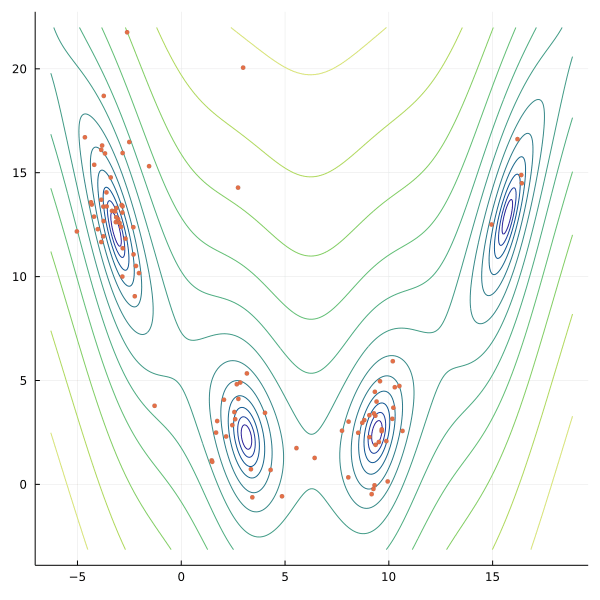

In [2]:
import Random
using Distributions

Random.seed!(0)

mutable struct Nest
    x::Vector{Float64}
    y::Float64
end

function initialize_population(population_size::Int64)::Vector{Nest}
    X = nothing
    for (lb, ub) in zip([xdomain[1], ydomain[1]], [xdomain[end], ydomain[end]])
        X_at_dim = rand(Distributions.Uniform(lb, ub), population_size)'
        X = X === nothing ? X_at_dim : vcat(X, X_at_dim)
    end
    return [Nest(Vector(x), f(Vector(x))) for x in eachcol(X)]
end

function cuckoo_search(
    f;
    flight_dist=Cauchy(0, 1),
    abandon_ratio=0.1,
    population_size=100,
    max_iter=10,
)
    history = []
    population = initialize_population(population_size)
    push!(history, population)
    n = length(population[1].x)

    abandon_lim = round(Int, population_size * abandon_ratio)
    for _ in 1:max_iter
        host, cuckoo = population[rand(1:population_size, 2)]
        x = cuckoo.x + rand(flight_dist, n)
        y = f(x)
        if y < host.y
            host.x = x
            host.y = y
        end

        # Abandon worst nests
        sorted_idx = sortperm(population, by=nest->nest.y, rev=true)
        for i in 1:abandon_lim
            j = rand(1:population_size - abandon_lim) + abandon_lim
            x = population[sorted_idx[j]].x + rand(flight_dist, n)
            population[sorted_idx[i]] = Nest(x, f(x))
        end
        push!(history, deepcopy(population))
    end
    min_idx = argmin([nest.y for nest in population])
    return population[min_idx].x, history
end

x, history = @time cuckoo_search(
    f;
    abandon_ratio=0.3,
    population_size=100,
    max_iter=10
)
display("Optimum: x=$(round.(x, digits=4))")
plot_animation(plot_learning, history)